This notebook shows how to use the CNN-LSTM model to predict the global temperature map.

By Weiwei Zhan

Reference: https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/CNN-LTSM_model.ipynb

In [1]:
!pip install cdsapi
!pip install utils
!pip install pygrib  # For PyGRIB
!pip install cfgrib xarray netCDF4 
!pip install keras-tuner --upgrade

import cdsapi
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

  Using cached utils-1.0.1-py2.py3-none-any.whl (21 kB)
  Obtaining dependency information for pygrib from https://files.pythonhosted.org/packages/39/54/3d3faee05f61f1bc3c3142c71c4bf262e6c14b0e2039beae192fe68a6cf8/pygrib-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached pygrib-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.8 kB)
Using cached pygrib-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.1 MB)
  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/2b/39/21f819fcda657c37519cf817ca1cd03a8a025262aad360876d2a971d38b3/keras_tuner-1.4.6-py3-none-any.whl.metadata
  Using cached keras_tuner-1.4.6-py3-none-any.whl.metadata (5.4 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
Using cached keras_tuner-1.4.6-py3-none-any.whl (128 kB)


2023-12-20 21:38:52.596297: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 21:38:52.638965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# api_key_content = """
# url: https://cds.climate.copernicus.eu/api/v2
# key: 267762:48ec6a98-a4a4-44c7-b5ab-ef4a29808b72
# """
# with open('/home/jovyan/.cdsapirc', 'w') as file:
#     file.write(api_key_content)


# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'variable': [
#             '100m_u_component_of_wind', '100m_v_component_of_wind', 'sea_surface_temperature',
#             'surface_pressure', 
#         ],
#         'year': [
#             '2022'
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area': [
#             42.25, -126, 32.5,
#             -114.2,
#         ],
#         'format': 'netcdf',
#     },
#     '2022.netcdf')

In [3]:
# Open the GRIB file using xarray and cfgrib
ds1012 = xr.open_dataset('/home/jovyan/2010-2012.netcdf')
ds1315 = xr.open_dataset('/home/jovyan/2013-2015.netcdf')
ds_train = xr.concat([ds1012,ds1315], dim='time')

ds_test = xr.open_dataset('/home/jovyan/2022.netcdf')

ds_train['ws'] = (((ds_train["u100"])**2+(ds_train["v100"])**2)**0.5)
ds_test['ws'] = (((ds_test["u100"])**2+(ds_test["v100"])**2)**0.5)


### 1. data preprocessing: prepare data for training & test sets

#### import data as training & test sets

In [4]:
X_train_xr = ds_train[['sst','sp']]
X_test_xr = ds_test[['sst','sp']]

y_train = ds_train['ws'].data
y_test  = ds_test['ws'].data

In [5]:
X_train_xr

<xarray.Dataset>
Dimensions:    (time: 52584, latitude: 40, longitude: 48)
Coordinates:
  * longitude  (longitude) float32 -126.0 -125.8 -125.5 ... -114.8 -114.5 -114.2
  * latitude   (latitude) float32 42.25 42.0 41.75 41.5 ... 33.0 32.75 32.5
  * time       (time) datetime64[ns] 2010-01-01 ... 2015-12-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float32 284.1 284.1 284.1 ... nan nan
    sp         (time, latitude, longitude) float32 1.013e+05 ... 9.909e+04
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-28 02:02:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

#### Data Normalization

In [8]:
# Compute mean/std of each variable for the whole dataset

predictors     = ['sst', 'sp']

    
# normalize each variables
# for var in predictors:
#     # training set
#     var_dims   = X_train_xr[var].dims
#     X_train_xr = X_train_xr.assign({var: (var_dims, (X_train_xr[var].data-X_train_xr[var].mean(dim='time'))/X_train_xr[var].std(dim='time'))})
    
#     # test set
#     var_dims  = X_test_xr[var].dims
#     X_test_xr = X_test_xr.assign({var: (var_dims, (X_test_xr[var].data-X_test_xr[var].mean(dim='time'))/X_test_xr[var].std(dim='time'))})
for var in predictors:
    # Calculate mean and std along 'time' dimension
    mean_train = X_train_xr[var].mean(dim='time')
    std_train = X_train_xr[var].std(dim='time')

    # Normalize training set
    normalized_train = (X_train_xr[var] - mean_train) / std_train
    X_train_xr = X_train_xr.assign({var: normalized_train})

    # Similar for test set
    mean_test = X_test_xr[var].mean(dim='time')
    std_test = X_test_xr[var].std(dim='time')
    normalized_test = (X_test_xr[var] - mean_test) / std_test
    X_test_xr = X_test_xr.assign({var: normalized_test})



y_train_np = y_train
y_test_np  = y_test


In [9]:
X_train_xr

<xarray.Dataset>
Dimensions:    (time: 52584, latitude: 40, longitude: 48)
Coordinates:
  * longitude  (longitude) float32 -126.0 -125.8 -125.5 ... -114.8 -114.5 -114.2
  * latitude   (latitude) float32 42.25 42.0 41.75 41.5 ... 33.0 32.75 32.5
  * time       (time) datetime64[ns] 2010-01-01 ... 2015-12-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float32 -0.8956 -0.9005 ... nan nan
    sp         (time, latitude, longitude) float32 -0.7805 -0.6965 ... 1.012
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-28 02:02:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [10]:
X_train_np = X_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data
X_test_np  = X_test_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(52584, 40, 48, 2) (52584, 40, 48) (8760, 40, 48, 2) (8760, 40, 48)


Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, n_latitude, n_longitude, n_features]**

Here the lag time step is set to **5**

In [11]:
# start = np.cumsum(X_length) - X_length
# end   = np.cumsum(X_length)

slider = 5
n_samples   = X_train_np.shape[0] - (slider-1)
n_lat,n_lon,n_feature = X_train_np.shape[1:]

X_train = np.zeros([n_samples,slider,n_lat,n_lon,n_feature])
y_train = np.zeros([n_samples,1,n_lat,n_lon])

X_train = np.array([X_train_np[i:i+slider] for i in range(0, X_train_np.shape[0]-slider+1)])
y_train = np.array([[y_train_np[i+slider-1]] for i in range(0, X_train_np.shape[0]-slider+1)])
        
X_test  = np.array([X_test_np[i:i+slider] for i in range(0, X_test_np.shape[0]-slider+1)])


In [12]:
print(X_train.shape,y_train.shape,X_test.shape)

(52580, 5, 40, 48, 2) (52580, 1, 40, 48) (8756, 5, 40, 48, 2)


### 2. Define the CNN-LSTM structure

In [12]:
n_filters   = 36 # number of filters
kernel_size = 2  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
n_lstm_unit = 100 # number of LSTM units
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 64   # batch size
num_epochs     = 100   # number of total epochs

In [21]:

## --------------------------------------

# model_mse = Sequential()

# model_mse.add(Input(shape=(slider, n_lat,n_lon,n_feature)))
# model_mse.add(TimeDistributed(Conv2DTranspose(n_filters, (kernel_size, kernel_size), 
#                                      padding='same', activation=activation), input_shape=(slider, n_lat,n_lon,n_feature)))
# model_mse.add(TimeDistributed(AveragePooling2D(pool_size)))
# model_mse.add(TimeDistributed(GlobalAveragePooling2D()))
# model_mse.add(LSTM(n_lstm_unit, activation=activation))
# model_mse.add(Dense(n_lat*n_lon))
# model_mse.add(Activation('relu'))
# model_mse.add(Reshape((1, n_lat, n_lon)))


# model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
# model_mse.summary()

## ----------------------------------------------------------------------------------------
## model using mae as loss function
model_mae = Sequential()

model_mae.add(TimeDistributed(Conv2DTranspose(n_filters, (kernel_size, kernel_size), 
                                      padding='same', activation=activation), input_shape=(slider, n_lat,n_lon,n_feature)))
model_mae.add(TimeDistributed(AveragePooling2D(pool_size)))
model_mae.add(TimeDistributed(GlobalAveragePooling2D()))
model_mae.add(LSTM(n_lstm_unit, activation=activation))
model_mae.add(Dense(n_lat*n_lon))
model_mae.add(Activation('relu'))
model_mae.add(Reshape((1, n_lat, n_lon)))
model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mae.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 5, 40, 48, 36)    324       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 5, 20, 24, 36)    0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 5, 36)            0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 100)               54800     
                                                                 
 dense_6 (Dense)             (None, 1920)              193920    
                                                      

### 3. Train & save the model

In [22]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# ###------------mse------------
# history_mse = model_mse.fit(X_train, y_train, 
#                     batch_size = minibatch_size,
#                     epochs = num_epochs,
#                     validation_split=0.2, verbose=1,
#                     callbacks=[early_stop])
###------------mae------------
history_mae = model_mae.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])


Epoch 1/100
658/658 [==============================] - 51s 76ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 2/100
658/658 [==============================] - 49s 75ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 3/100
658/658 [==============================] - 49s 75ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 4/100
658/658 [==============================] - 49s 75ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 5/100
658/658 [==============================] - 49s 75ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 6/100
658/658 [==============================] - 48s 74ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 7/100
658/658 [==============================] - 49s 74ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 8/100
658/658 [==============================] - 49s 74ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 9/100
658/658 [==============================] - 48s 74ms/step - loss: 5.3694 - val_loss: 4.9775
Epoch 10/100
658/658 [==============================] - 49s 74ms/step - l

NameError: name 'history_mse' is not defined

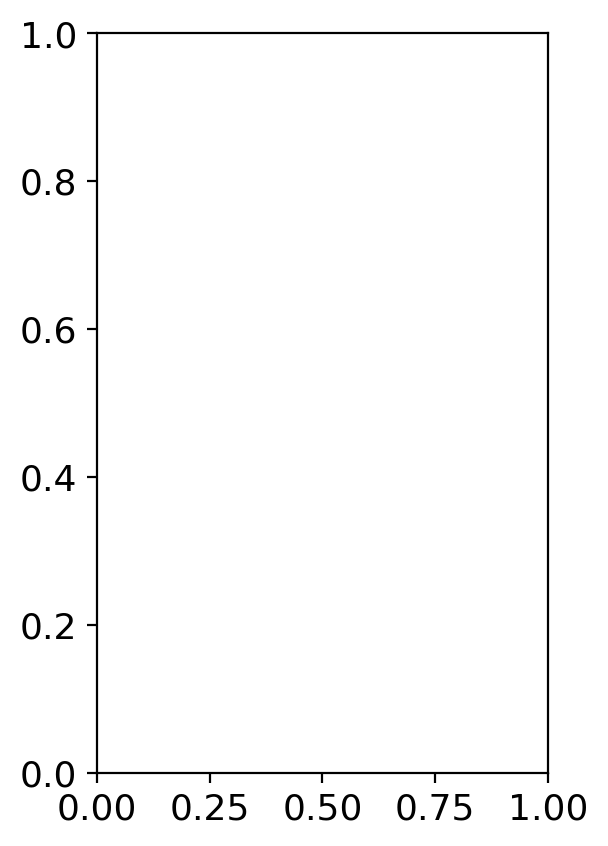

In [18]:
# ## plot history
# # ---------- ----------
# plt.subplot(1, 2, 1)
# plt.plot(history_mse.history['loss'])
# plt.plot(history_mse.history['val_loss'])

# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ----------  ----------
# plt.subplot(1, 2, 2)
plt.plot(history_mae.history['loss'])
plt.plot(history_mae.history['val_loss'])

plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.savefig('my_plot.png', format='png')

In [21]:
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')


In [22]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_mse.save(os.path.join(model_path,'CNN-LSTM_model_mse.h5'))
model_mae.save(os.path.join(model_path,'CNN-LSTM_model_mae.h5'))

NameError: name 'model_mae' is not defined

### 4. Evaluate the trained model

In [ ]:
# reload the saved model
model_mse = load_model(os.path.join(model_path,'CNN-LSTM_model_mse.h5'))
model_mae = load_model(os.path.join(model_path,'CNN-LSTM_model_mae.h5'))

In [23]:
###------------mse------------
y_test_mse_pre = model_mse.predict(X_test)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 40, 48)
y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(ws=(['time', 'latitude', 'longitude'], y_test_mse_pre)))
###------------mae------------
y_test_mae_pre = model_mae.predict(X_test)
y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], 40, 48)
y_test_mae_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(ws=(['time', 'latitude', 'longitude'], y_test_mae_pre)))

274/274 [==============================] - 19s 68ms/step


NameError: name 'model_mae' is not defined

In [24]:
y_test_mse_pre

<xarray.Dataset>
Dimensions:    (time: 8756, latitude: 40, longitude: 48)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01T04:00:00 ... 2022-12-31T23:00:00
  * latitude   (latitude) float32 42.25 42.0 41.75 41.5 ... 33.0 32.75 32.5
  * longitude  (longitude) float32 -126.0 -125.8 -125.5 ... -114.8 -114.5 -114.2
Data variables:
    ws         (time, latitude, longitude) float32 9.734 9.88 ... 4.664 4.555

First we check whether the ML model can capture the spatial distribution of global temperature

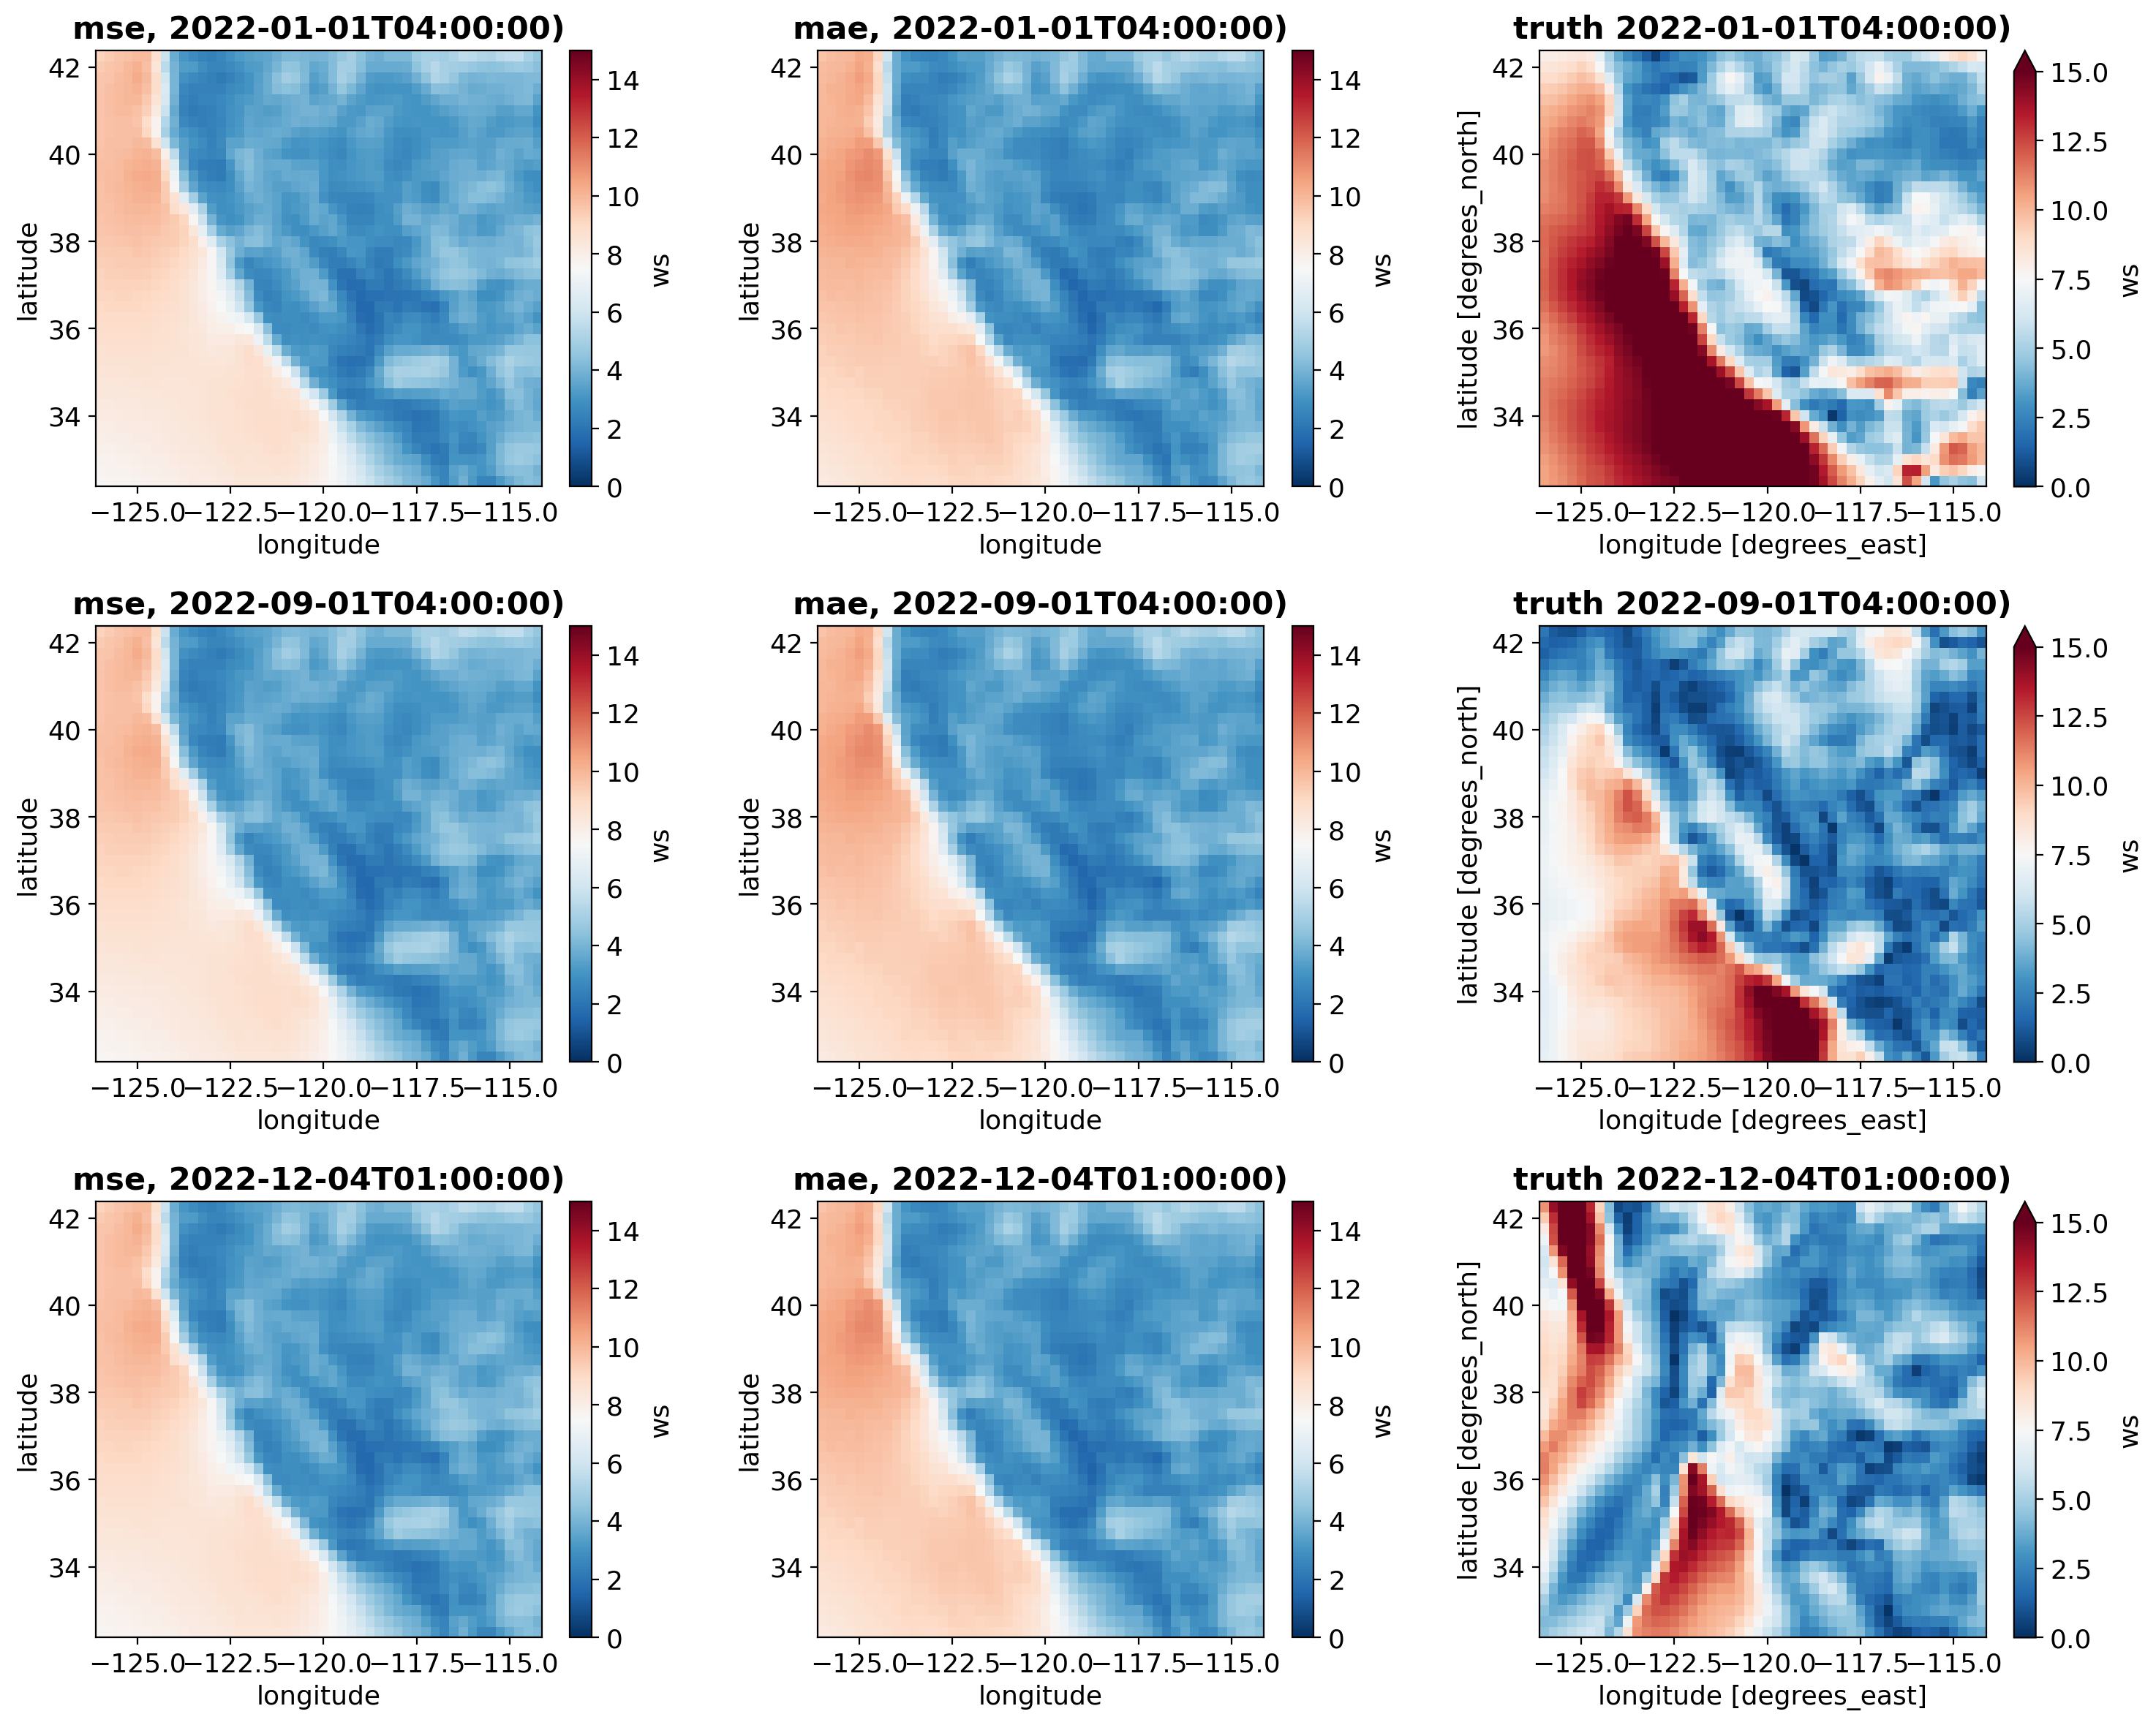

In [54]:
fig, axes = plt.subplots(figsize=(15,12),ncols=3,nrows=3)

yrs = ['2022-01-01T04:00:00', '2022-09-01T04:00:00', '2022-12-04T01:00:00']
vmin, vmax    = 0, 15
cmap = 'RdBu_r'
y_test_mse_pre.ws.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.ws.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)
ds_test.ws.sel(time=yrs[0]).plot(ax=axes[0,2], vmin=vmin, vmax=vmax,cmap=cmap)



y_test_mse_pre.ws.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.ws.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)
ds_test.ws.sel(time=yrs[1]).plot(ax=axes[1,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.ws.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.ws.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)
ds_test.ws.sel(time=yrs[2]).plot(ax=axes[2,2], vmin=vmin, vmax=vmax,cmap=cmap)



for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 3 == 0:
        ax.set_title(f'mse, {yrs[i//3]})',fontweight='bold')
    # middle column: model prediction
    elif i % 3 == 1:
        ax.set_title(f'mae, {yrs[i//3]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'truth {yrs[i//3]})',fontweight='bold')
plt.tight_layout()
plt.savefig('my_plot.png', format='png')

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

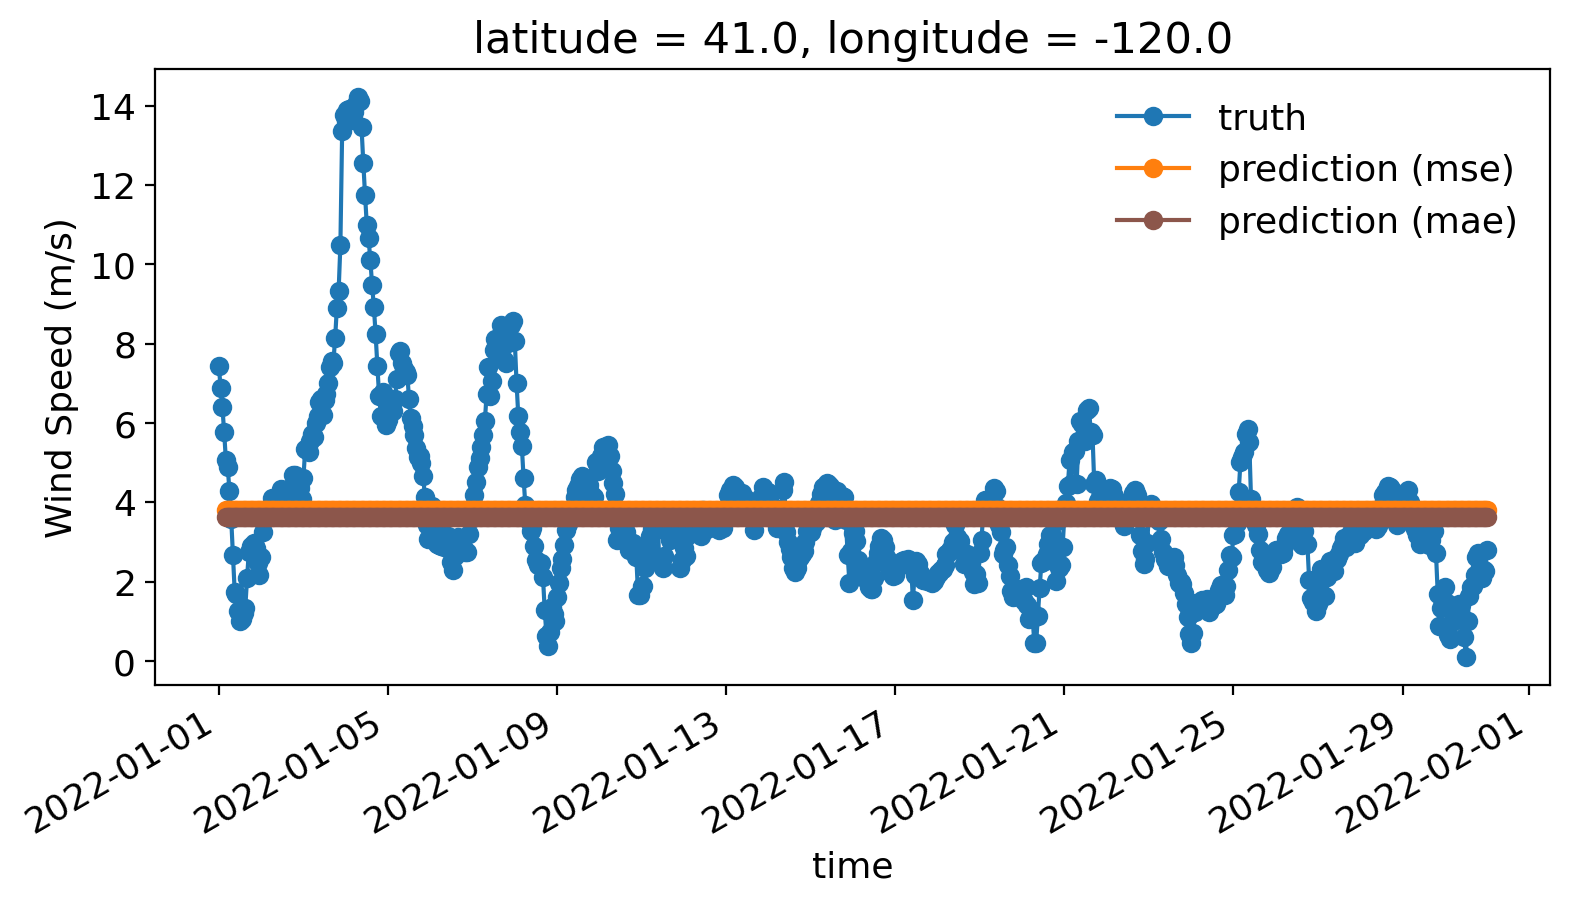

In [56]:
lat = 41
lon = -120

fig,ax = plt.subplots(figsize=(9,4))
#ds_test_sub = ds_test
ds_test_sub = ds_test.ws.sel(time=slice("2022-01-01T00:00:00.000000000","2022-01-31T00:00:00.000000000"))
ds_test_sub.sel(latitude=lat,longitude=lon,method='nearest').plot(marker='o',ax=ax,label='truth')

y_test_mse_pre_sub = y_test_mse_pre.ws.sel(latitude=lat,longitude=lon,method='nearest')
y_test_mse_pre_sub.sel(time=slice("2022-01-01T00:00:00.000000000","2022-01-31T00:00:00")).plot(marker='o',ax=ax,label='prediction (mse)')

y_test_mae_pre_sub = y_test_mae_pre.ws.sel(time=slice("2022-01-01T00:00:00","2022-01-31T00:00:00"))
y_test_mae_pre_sub.sel(latitude=lat,longitude=lon,method='nearest').plot(marker='o',ax=ax,color='tab:brown',label='prediction (mae)')
ax.legend()
ax.set_ylabel('Wind Speed (m/s)')
plt.savefig('my_plot.png', format='png')

Let's check the statistical comparison between truth and prediction.

In [36]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = ds_test.sel(latitude=lat,longitude=lon,method='nearest').ws.values
nyc_test_mse_pre = y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').ws.values
nyc_test_mae_pre = y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').ws.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = ds_test.sel(latitude=lat,longitude=lon,method='nearest').ws.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction_mse"] = np.nan
df_nyc_test.loc[4:, "prediction_mse"] = nyc_test_mse_pre # prediction start from 2019
df_nyc_test["prediction_mae"] = np.nan
df_nyc_test.loc[4:, "prediction_mae"] = nyc_test_mae_pre # prediction start from 2019
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

                 time     truth  prediction_mse  prediction_mae
0 2022-01-01 00:00:00  7.428037             NaN             NaN
1 2022-01-01 01:00:00  6.884225             NaN             NaN
2 2022-01-01 02:00:00  6.414836             NaN             NaN
3 2022-01-01 03:00:00  5.765931             NaN             NaN
4 2022-01-01 04:00:00  5.060952        3.802787        3.630495
5 2022-01-01 05:00:00  4.901787        3.802787        3.630495
6 2022-01-01 06:00:00  4.297790        3.802787        3.630495
7 2022-01-01 07:00:00  3.587674        3.802787        3.630495
8 2022-01-01 08:00:00  2.674126        3.802787        3.630495
9 2022-01-01 09:00:00  1.741296        3.802787        3.630495


,time,truth,prediction_mse,prediction_mae
count,8760,8760.000000,8756.000000,8756.000000
mean,2022-07-02 11:30:00,3.942680,3.802787,3.630495
min,2022-01-01 00:00:00,0.018362,3.802787,3.630495
25%,2022-04-02 05:45:00,2.297813,3.802787,3.630495
50%,2022-07-02 11:30:00,3.445284,3.802787,3.630495
75%,2022-10-01 17:15:00,5.124836,3.802787,3.630495
max,2022-12-31 23:00:00,14.305438,3.802787,3.630495
std,NaN,2.275985,0.000000,0.000000


Finally we check whether the ML model can capture the time series of global average temperature 

In [48]:
def global_mean_std_plot(X,label,color,ax,var='ws'):
    weights  = np.cos(np.deg2rad(X.latitude))
    ws_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    ws_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, ws_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,ws_mean+ws_std,ws_mean-ws_std,facecolor=color,alpha=0.2)

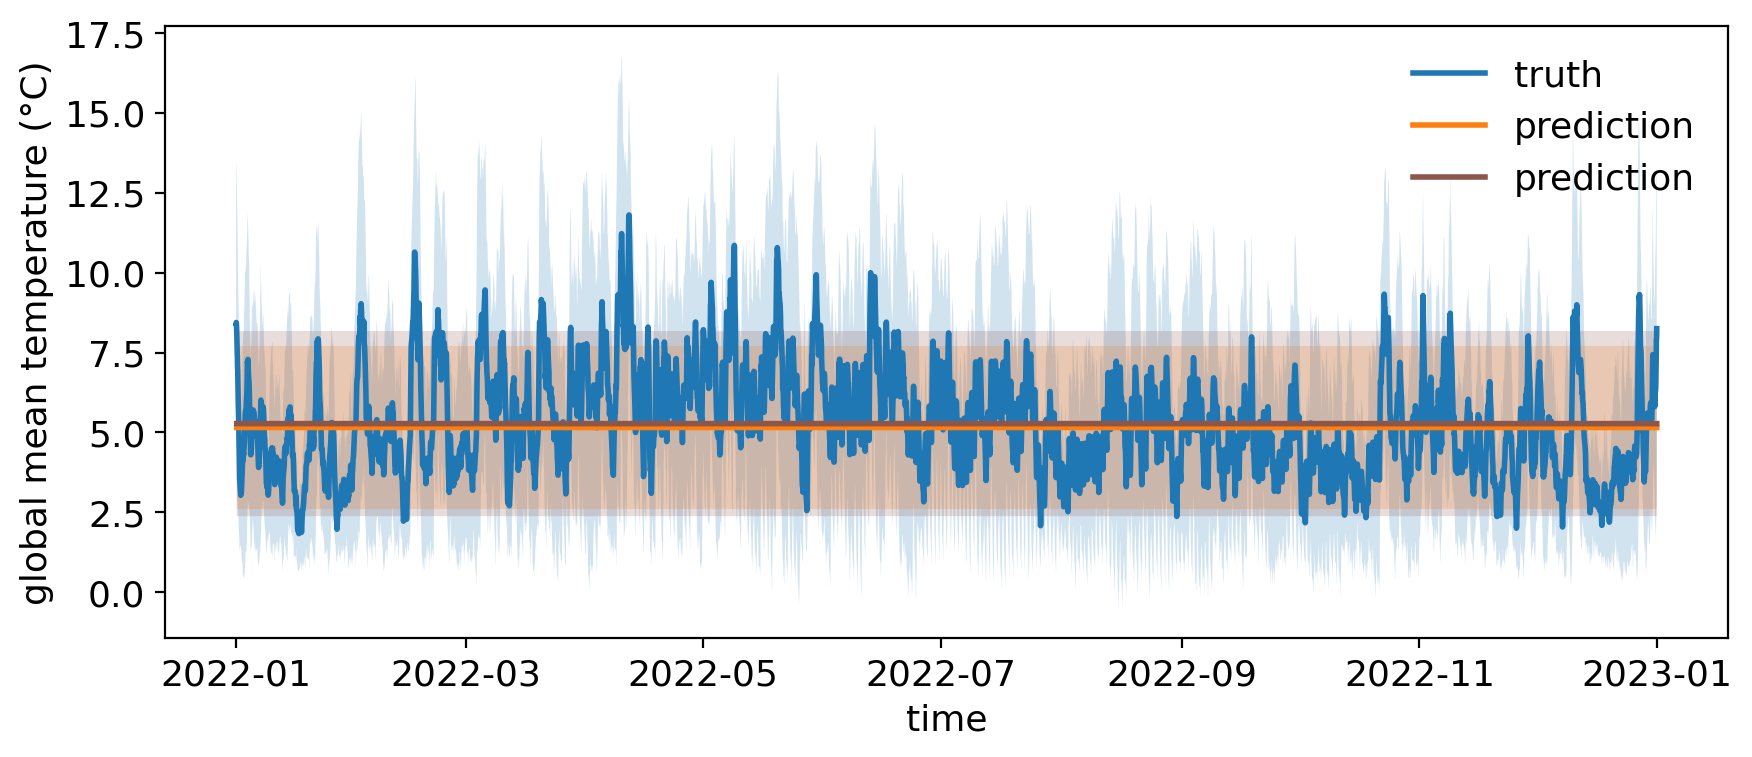

In [57]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(ds_test,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mse_pre,label='prediction',ax=ax,color='tab:orange')
global_mean_std_plot(y_test_mae_pre,label='prediction',ax=ax,color='tab:brown')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend()
plt.tight_layout()

plt.savefig('my_plot.png', format='png')

In [52]:
# get global mean temperature
def global_mean(X,var='ws'):
    weights  = np.cos(np.deg2rad(X.latitude))
    ws_mean = X['ws'].weighted(weights).mean(['latitude', 'longitude']).data
    return ws_mean

ws_mean_xr = global_mean(ds_test)
ws_mean_mse_pre = global_mean(y_test_mse_pre)
ws_mean_mae_pre = global_mean(y_test_mae_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = ds_test.sel(latitude=lat,longitude=lon,method='nearest').ws.to_dataframe().index
df_globalmean_test["truth"] = ws_mean_xr
df_globalmean_test["prediction_mse"] = np.nan
df_globalmean_test.loc[4:, "prediction_mse"] = ws_mean_mse_pre # prediction start from 2019
df_globalmean_test["prediction_mae"] = np.nan
df_globalmean_test.loc[4:, "prediction_mae"] = ws_mean_mae_pre # prediction start from 2019
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

                 time     truth  prediction_mse  prediction_mae
0 2022-01-01 00:00:00  8.404290             NaN             NaN
1 2022-01-01 01:00:00  8.440994             NaN             NaN
2 2022-01-01 02:00:00  8.411901             NaN             NaN
3 2022-01-01 03:00:00  8.299248             NaN             NaN
4 2022-01-01 04:00:00  8.161176        5.154787        5.276374
5 2022-01-01 05:00:00  7.965810        5.154787        5.276374
6 2022-01-01 06:00:00  7.807757        5.154787        5.276374
7 2022-01-01 07:00:00  7.556662        5.154787        5.276374
8 2022-01-01 08:00:00  7.301312        5.154787        5.276374
9 2022-01-01 09:00:00  7.004755        5.154787        5.276374


,time,truth,prediction_mse,prediction_mae
count,8760,8760.000000,8756.000000,8756.000000
mean,2022-07-02 11:30:00,5.332764,5.154787,5.276374
min,2022-01-01 00:00:00,1.833208,5.154787,5.276374
25%,2022-04-02 05:45:00,4.123814,5.154787,5.276374
50%,2022-07-02 11:30:00,5.165375,5.154787,5.276374
75%,2022-10-01 17:15:00,6.339730,5.154787,5.276374
max,2022-12-31 23:00:00,11.805041,5.154787,5.276374
std,NaN,1.602602,0.000000,0.000000
